<a href="https://colab.research.google.com/github/jchen8000/DemystifyingLLMs/blob/main/4_Pre-Training/En2Fr_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. Pre-Training

**Machine Translation: English to French**

*   4.01 Install and Import Libraries
*   4.02 Global Parameters
*   4.2 Dataset and Tokenization
*   4.3 Load Data in Batch
*   4.4 Pre-Training nn.Transformer Model
*   4.5 Inference


This script is tested and working on Google Colab with T4 GPU, which might take 40 to 60 minutes. This script uses the HuggingFace datasets, as a prerequisite you need a HuggingFace account and obtain a access token, see https://huggingface.co/docs/hub/security-tokens. You should add the token to Colab Secrets as HF_TOKEN to run this script.

## 4.01 Install and Import Libraries

Dataset is downloaded from
https://www.kaggle.com/datasets/devicharith/language-translation-englishfrench

Make sure to put the CSV file in "datasets/eng_-french.csv", and a "outputs" folder exists.


In [ ]:
%pip install \
  numpy==2.0.2 \
  matplotlib==3.10.0 \
  torch==2.9.0+cu126 \
  torchvision==0.24.0+cu126 \
  torchaudio==2.9.0+cu126 \
  datasets==4.0.0 \
  spacy==3.8.11 \
  nltk==3.9.1 

# Download SpaCy models
!python -m spacy download fr_core_news_sm
!python -m spacy download en_core_web_sm

In [ ]:
import torch
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import csv
import spacy
import random
import time
import math
import matplotlib.pyplot as plt

## 4.02 Global Parameters

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
epochs = 100
torch.manual_seed(42)
batch_size = 128
learning_rate=1e-3
PAD_IDX = 0
SOS_IDX = 1
EOS_IDX = 2

D_MODEL = 256
NHEAD = 4
NENC_LAYER = 3
NDEC_LAYER = 3
FFN_DIM = 256
DROPOUT = 0.25
MAX_LENGTH = 512
MODEL_PATH = 'outputs/en2fr_checkpoint_30epochs.pth'

## 4.2. Dataset and Tokenization



In [ ]:
# Load spacy models for tokenization
spacy_fr = spacy.load("fr_core_news_sm")
spacy_en = spacy.load("en_core_web_sm")

# Tokenization functions
def tokenize_fr(text):
    return [tok.text for tok in spacy_fr.tokenizer(text)]  #[::-1]  # Reversing for better learning in LSTM

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]


In [ ]:
import os
import requests
file_path = 'datasets/eng_-french.csv'
file_url = 'https://raw.githubusercontent.com/jchen8000/DemystifyingLLMs/refs/heads/main/4_Pre-Training/datasets/eng_-french.csv'

# Ensure the datasets directory exists
os.makedirs('datasets', exist_ok=True)

# Check if file exists, if not download it
if not os.path.exists(file_path):
    print("File not found. Downloading from GitHub...")
    response = requests.get(file_url)
    if response.status_code == 200:
        with open(file_path, 'wb') as f:
            f.write(response.content)
        print("Download complete.")
    else:
        raise Exception(f"Failed to download file. Status code: {response.status_code}")

dataset = []
with open(file_path, mode='r', encoding='utf-8') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    line_count = 0
    for row in csv_reader:
        dataset.append([row["English words/sentences"], row["French words/sentences"]])
        line_count += 1
    print(f'Processed {line_count} lines.')

train_set, valid_set = train_test_split(dataset, test_size=0.1)

Processed 175621 lines.


In [ ]:
# Build vocabularies
def build_vocab(texts, tokenizer):
    vocabs = []
    max_length = 0
    for text in texts:
        vocabs.extend(tokenizer(text))
        if len(text) > max_length:
          max_length = len(text)
    return sorted(list(set(vocabs))), max_length

# Vocab transforms and special tokens
PAD_TOKEN = "<PAD>"  # Padding token
SOS_TOKEN = "<SOS>"  # Start-of-sentence token
EOS_TOKEN = "<EOS>"  # End-of-sentence token
UNK_TOKEN = "<UNK>"  # Unknown token

# Create vocabularies and add special tokens to them
en_vocab, en_max_len = build_vocab([dataset[i][0] for i in range(len(dataset))], tokenize_en)
en_vocab = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN] + en_vocab
fr_vocab, fr_max_len = build_vocab([dataset[i][1] for i in range(len(dataset))], tokenize_fr)
fr_vocab = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN] + fr_vocab

SRC_VOCAB_SIZE = len(en_vocab)
TRG_VOCAB_SIZE = len(fr_vocab)

print("Train size:", len(train_set))
print("Validation size:", len(valid_set))
print("EN vocab: %d, max_length: %d" % (SRC_VOCAB_SIZE, en_max_len) )
print("FR vocab: %d, max_length: %d" % (TRG_VOCAB_SIZE, fr_max_len) )

Train size: 158058
Validation size: 17563
EN vocab: 15914, max_length: 262
FR vocab: 26328, max_length: 325


## 4.3 Load Data in Batch

In [ ]:
# Tokenize and create a custom dataset
class En2De_Dataset(Dataset):
    def __init__(self, raw_dataset, src_tokenizer, trt_tokenizer, vocab_transforms):
        self.raw_dataset = raw_dataset
        self.src_tokenizer = src_tokenizer
        self.trt_tokenizer = trt_tokenizer
        self.vocab_transforms = vocab_transforms

    def __len__(self):
        return len(self.raw_dataset)

    def __getitem__(self, idx):
        src = self.src_tokenizer(self.raw_dataset[idx][0])
        src = self.vocab_transforms["en"](src)
        tgt = self.trt_tokenizer(self.raw_dataset[idx][1])
        tgt_in = self.vocab_transforms["fr"]([SOS_TOKEN] + tgt)
        tgt_out = self.vocab_transforms["fr"](tgt + [EOS_TOKEN])
        return src, tgt_in, tgt_out

class VocabTokenizer(nn.Module):
    def __init__(self, vocabulary):
        super().__init__()
        self.vocab_size = len(vocabulary)
        self.idx2word = {index:word for index, word in enumerate(vocabulary)}
        self.word2idx = {word:index for index, word in enumerate(vocabulary)}

    def encode(self, text):
        return [self.word2idx[w] for w in text]

    def decode(self, token):
        return [self.idx2word[i] for i in token]

    def __call__(self, text, encode=True):
        if encode:
            return self.encode(text)
        else:
            return self.decode(text)


vocab_tokenizers = {
    'en': VocabTokenizer(en_vocab),
    'fr': VocabTokenizer(fr_vocab),
}

def padding(batch):
    # pad the sequences of the current batch
    src = [torch.tensor(item[0]) for item in batch]
    tgt_in = [torch.tensor(item[1]) for item in batch]
    tgt_out = [torch.tensor(item[2]) for item in batch]
    return  pad_sequence(src, padding_value=0, batch_first=True), \
            pad_sequence(tgt_in, padding_value=0, batch_first=True), \
            pad_sequence(tgt_out, padding_value=0, batch_first=True)

# Create training and validation datasets
train_data = En2De_Dataset(train_set, tokenize_en, tokenize_fr, vocab_tokenizers)
val_data = En2De_Dataset(valid_set, tokenize_en, tokenize_fr, vocab_tokenizers)
train_loader = DataLoader(train_data, batch_size=batch_size, collate_fn=padding, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, collate_fn=padding, shuffle=False)


## 4.4 Pre-Training nn.Transformer Model

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=DROPOUT):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe_table', pe)

    def forward(self, x):
        x = x + self.pe_table[:, :x.size(1), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout=DROPOUT, max_seq_length=MAX_LENGTH):
        super(TransformerModel, self).__init__()

        self.source_embedding = nn.Embedding(src_vocab_size, d_model)
        self.target_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,  # input and output as (batch, seq, feature)
        )
        self.output_layer = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_padding_mask):
        src_emb = self.positional_encoding(self.source_embedding(src))
        tgt_emb = self.positional_encoding(self.target_embedding(tgt))

        output = self.transformer(
            src_emb, tgt_emb,
            src_mask, tgt_mask,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=memory_padding_mask)
        return self.output_layer(output)

    def encoder(self, src, src_mask):
        return self.transformer.encoder(self.positional_encoding(self.source_embedding(src)), src_mask)

    def decoder(self, tgt, memory, tgt_mask):
        return self.transformer.decoder(self.positional_encoding(self.target_embedding(tgt)), memory, tgt_mask)

# Instantiate the Transformer model
model = TransformerModel(
    src_vocab_size = SRC_VOCAB_SIZE,
    tgt_vocab_size = TRG_VOCAB_SIZE,
    d_model = D_MODEL,
    nhead = NHEAD,
    num_encoder_layers = NENC_LAYER,
    num_decoder_layers = NDEC_LAYER,
    dim_feedforward = FFN_DIM,
).to(device)

In [ ]:
total_parameter = sum(p.numel() for p in model.parameters())
print(f"Parameters of the model: {total_parameter:,}")

Parameters of the model: 20,746,968


Create masks, loss function, and optimizer

In [ ]:
def create_mask(src, tgt, pad_idx=PAD_IDX):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)
    tgt_mask = model.transformer.generate_square_subsequent_mask(tgt_seq_len)

    src_padding_mask = (src == pad_idx)
    tgt_padding_mask = (tgt == pad_idx)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)

Training loop

In [ ]:
history_loss = []
history_val = []

start_time = time.time()
for epoch in range(epochs):
    model.train()
    train_batches = len(train_loader)
    train_losses = 0
    for i, [src, tgt_in, tgt_out] in enumerate(train_loader):
        src =  src.to(device)
        tgt_in =  tgt_in.to(device)
        tgt_out = tgt_out.to(device)
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_in)
        src_mask = src_mask.to(device)
        tgt_mask = tgt_mask.to(device)
        src_padding_mask = src_padding_mask.to(device)
        tgt_padding_mask = tgt_padding_mask.to(device)

        optimizer.zero_grad()

        logits = model(src, tgt_in, src_mask, tgt_mask,
                       src_padding_mask, tgt_padding_mask, src_padding_mask)
        logits = logits.reshape(-1, logits.size(-1))
        train_loss = criterion(logits, tgt_out.view(-1))
        train_losses += train_loss.item()

        train_loss.backward()
        optimizer.step()

    model.eval()
    val_batches = len(val_loader)
    val_losses = 0
    with torch.no_grad():  # Disable gradient computation
        for i, [val_src, val_tgt_in, val_tgt_out] in enumerate(val_loader):
            val_src = val_src.to(device)
            val_tgt_in = val_tgt_in.to(device)
            val_tgt_out = val_tgt_out.to(device)

            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(val_src, val_tgt_in)
            tgt_mask = tgt_mask.to(device)
            output = model(val_src, val_tgt_in, src_mask, tgt_mask,
                           src_padding_mask, tgt_padding_mask, src_padding_mask)

            output = output.reshape(-1, output.size(-1))
            val_loss = criterion(output, val_tgt_out.view(-1))
            val_losses += val_loss.item()

    print('Epoch %d' % (epoch+1),
          'Train loss = {:.6f};'.format(train_losses/train_batches),
          'Validation loss = {:.6f}'.format(val_losses / val_batches))
    history_loss.append(train_losses/train_batches)
    history_val.append(val_losses/val_batches)

end_time = time.time()
print(f"Training time: {(end_time-start_time):.8f} seconds")

Epoch 1 Train loss = 4.076699; Validation loss = 3.189777
Epoch 2 Train loss = 3.148219; Validation loss = 2.699774
Epoch 3 Train loss = 2.776775; Validation loss = 2.301756
Epoch 4 Train loss = 2.462861; Validation loss = 2.003357
Epoch 5 Train loss = 2.225265; Validation loss = 1.832292
Epoch 6 Train loss = 2.062204; Validation loss = 1.736535
Epoch 7 Train loss = 1.943338; Validation loss = 1.646586
Epoch 8 Train loss = 1.849146; Validation loss = 1.588697
Epoch 9 Train loss = 1.776797; Validation loss = 1.535032
Epoch 10 Train loss = 1.719013; Validation loss = 1.502897
Epoch 11 Train loss = 1.670951; Validation loss = 1.471033
Epoch 12 Train loss = 1.630684; Validation loss = 1.445142
Epoch 13 Train loss = 1.594395; Validation loss = 1.414609
Epoch 14 Train loss = 1.563718; Validation loss = 1.394382
Epoch 15 Train loss = 1.537237; Validation loss = 1.384010
Epoch 16 Train loss = 1.512805; Validation loss = 1.371281
Epoch 17 Train loss = 1.491774; Validation loss = 1.349219
Epoch 

Visualize training progress

In [ ]:
import os
os.makedirs("outputs", exist_ok=True)

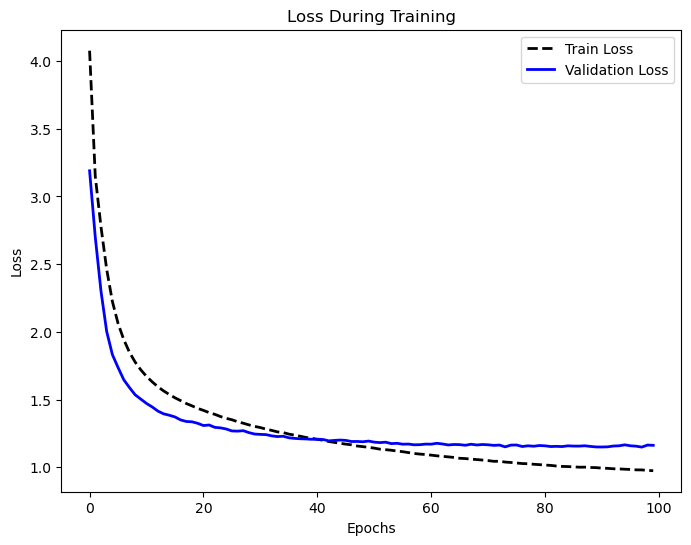

In [ ]:
plt.figure(figsize=(8, 6))
plt.title("Loss During Training")
plt.plot(history_loss, label="Train Loss", c='k', lw=2, ls='--')
plt.plot(history_val, label="Validation Loss", c='b', lw=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("outputs/en2fr_training.svg", format="svg", dpi=150, transparent=True, bbox_inches='tight')
plt.show()

Save the model:

In [ ]:
torch.save(model, MODEL_PATH)

Load the model:

In [ ]:
# Load the model
# model = torch.load(MODEL_PATH)

## 4.5 Inference

In [ ]:
def translate(model, src, max_len=MAX_LENGTH, start_symbol=SOS_IDX, end_symbol=EOS_IDX):
    model.eval()
    src = src.to(device)
    src_mask = torch.zeros((src.shape[1], src.shape[1]),device=device).type(torch.bool).to(device)
    memory = model.encoder(src, src_mask)
    memory = memory.to(device)
    tgt = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        _, tgt_mask, _, _ = create_mask(src, tgt)
        tgt_mask = tgt_mask.to(device)
        out = model.decoder(tgt, memory, tgt_mask)
        prob = model.output_layer(out[:, -1])
        next_word = torch.argmax(prob.squeeze(0), dim=-1, keepdim=False)
        tgt = torch.cat([tgt, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == end_symbol:
            break
    return tgt

In [ ]:
test_loader = DataLoader(val_data, batch_size=1, collate_fn=padding, shuffle=False)
test_iterator = iter(test_loader)
for i in range(10):
    source, target, _ = next(test_iterator)
    target = target[:, 1:]
    output = translate(model, source)
    print("SOURCE:\t"," ".join(vocab_tokenizers["en"](list(source.view(-1).cpu().numpy()), encode=False)) )
    print("TARGET:\t"," ".join(vocab_tokenizers["fr"](list(target.view(-1).cpu().numpy()), encode=False)) )
    print("PREDICT:", " ".join(vocab_tokenizers["fr"](list(output.view(-1).cpu().numpy()), encode=False)).replace("<SOS> ", "").replace("<EOS>", "") )
    print("")

SOURCE:	 You 're not very organized , are you ?
TARGET:	 Vous n' êtes pas très organisés , n' est -ce pas ?
PREDICT: Vous n' êtes pas très organisée , n' est -ce pas ? 

SOURCE:	 Will you help me with my homework ?
TARGET:	 M' aideras - tu pour mes devoirs   ?
PREDICT: Me aideras - tu pour mes devoirs ? 

SOURCE:	 He made me a cake .
TARGET:	 Il me confectionna un gâteau .
PREDICT: Il m' a confectionné un gâteau . 

SOURCE:	 I thought I told you not to do that in here .
TARGET:	 Je pensais vous avoir dit de ne pas faire cela ici .
PREDICT: Je pensais t' avoir dit de ne pas faire ça ici . 

SOURCE:	 Do you have a backup plan ?
TARGET:	 Est -ce que tu as un plan de secours   ?
PREDICT: As - tu un plan de secours ? 

SOURCE:	 He cracked up .
TARGET:	 Il a pété les plombs .
PREDICT: Il a fait fausse . 

SOURCE:	 It has happened before and it will probably happen again .
TARGET:	 Ca s' est produit auparavant et ça se produira probablement à nouveau .
PREDICT: Ça s' est produit avant et ça s